# Capstone2 Feature Engineering Mental Health Dataset

## Table of Contents
1. [Overview](#1.-Overview)
2. [Import Libraries](#2.-Import-Libraries)
3. [Common Routines for Data Analysis](#3.-Common-Routines-for-Data-Analysis)
4. [Load Data](#4.-Load-Data)
5. [Analyze Data](#5.-Analyze-Data)
6. [Initial Model - Logistic Regression](#6.-Initial-Model---Logistic-Regression)
    - 6.1 [Train Global Model](#6.1-Train-Global-Model)
    - 6.2 [Train Country Models](#6.2-Train-Country-Models)
    - 6.3 [Cross-Validation Score by Country](#6.3-Cross-Validation-Score-by-Country)
    - 6.4 [Train High-impact and Low-impact Segments separately](#6.4-Train-High-impact-and-Low-impact-Segments-separately)
        - 6.4.1 [Train High-impact model](#6.4.1-Train-High-impact-model)
        - 6.4.2 [Train Low-impact model](#6.4.2-Train-Low-impact-model)
7. [Summary](#7.-Summary)

## 1. Overview

The purpose of this feature engineering notebook is to explore and develop an initial model for analyzing the predictive performance of mental health data. 

It aims to evaluate the model's effectiveness through a global approach, as well as by assessing its performance across various countries.


## 2. Import Libraries

In [1]:
%config InlineBackend.figure_format = 'retina'
# python libs
from typing import List, TypeVar

# Import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data, stats libs
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## 3. Common Routines for Data Analysis

### 3.1 Train/Test Split - No Duplicates

In [2]:

def train_test_split_no_duplicates(data, target: str, 
                                   test_size=0.25, random_state=None):
    """
    Train/test split data while ensuring no duplicates are introduced in the test set
    """
    # Identify duplicates
    duplicate_indices = data.duplicated(keep=False)
    
    # Separate data into duplicates and non-duplicates
    data_no_duplicates = data[~duplicate_indices]
    data_duplicates = data[duplicate_indices]
    
    # Split the data without duplicates first
    X_train, x_test, y_train, y_test = train_test_split(
        data_no_duplicates.drop(columns=[target], axis=1),
        data_no_duplicates[target],
        test_size=test_size,
        random_state=random_state
    )
    
    # Add duplicates to the training set
    if not data_duplicates.empty:
        X_train = pd.concat([X_train, data_duplicates.drop(columns=[target])], axis=0)
        y_train = pd.concat([y_train, data_duplicates[target]], axis=0)
    
    return X_train, x_test, y_train, y_test

### 3.2 Train/Test, Report Performance

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def train_report_scores(data, target: str, model: BaseEstimator, 
                      plot=False, test_size=0.2, random_state=None) -> (str, float, float):
    """
    Trains a ML model based on a given dataset and evaluates its performance.
    Print evaluation report
    
    Parameters:
    ----------
    data : pd.DataFrame
        A dataframe containing the features and target data
    target : str
        Name of the column in the data that contains the target labels
    model : BaseEstimator interface
        An instance of the sklearn model to be trained. 
    plot : bool
        Display graphs
    test_size : float, optional, default is 0.25
        Fraction of the data to use as the test dataset.
    random_state : int, optional, default is None
        Controls randomness of the split.
        
    Returns: 
    -------
    Accuracy Score : float
    
    """
    # Split data
    #
    
    X_train, x_test, y_train, y_test = train_test_split_no_duplicates(
        data, 
        target, 
        test_size, 
        random_state
    )

    # Train, evaluate model
    #

    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict probabilities and classes for test set
    y_probs = model.predict_proba(x_test)[:, 1]  # Probability of the positive class
    y_pred = model.predict(x_test)

    # Check that the target has at least 2 classes, otherwise this is failed.
    vc = y_test.value_counts()
    if vc.count() == 1:
        return (
            f'Test failed! The test variable only has one category ({"Yes" if vc.keys()[0] == 1 else "No"}).',
            0,
            0
        )

    # Calculate F1 Score
    f1 = f1_score(y_test, y_pred)
    # Calculate AUC
    auc = roc_auc_score(y_test, y_probs)
    _score = accuracy_score(y_test, y_pred)
    
    if f1 != 1.0 and auc != 1.0:
        if plot == True:
            # Print Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            print("\nConfusion Matrix (Treatment Required):")
            print(f' No: {cm[0]}')
            print(f'Yes: {cm[1]}')
            
            # Print Classification Report
            report = classification_report(y_test, y_pred)
            print("\nClassification Report:")
            print(report)

            # Plot precision-recall curve
            #
            
            # Calculate precision and recall
            precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
            # Calculate average precision score
            avg_precision = average_precision_score(y_test, y_probs)
            fig, ax = plt.subplots(1, 2, figsize=(6, 3))
            
            ax[0].plot(recall, precision, marker='.', 
                     label='Precision-Recall curve (AP={:.2f})'.format(avg_precision))
            ax[0].set_title('Precision-Recall Curve')
            
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.grid()
    
            # Plot ROC Curve
            #
            
            RocCurveDisplay.from_estimator(model, x_test, y_test, ax=ax[1])
            ax[1].set_title('ROC Curve')
            plt.grid()

            plt.tight_layout()
            _ = plt.show()

            # We have not accounted for duplicates in the Cross-V score. There will be effects, but can live it for now.
            scores = cross_val_score(model, data.drop(columns=target), data[target], cv=5)
            print(f'Cross-V: {scores.mean():.4f}')
    
    return ('', _score, auc)
    

### 3.3  Pipeline Wrapper

In [4]:

# Create a type variable that is bounded by BaseEstimator
T = TypeVar('T', bound=BaseEstimator)

def create_pipeline(estimators: List[T]) -> 'Pipeline':
    # Process estimators in order starting with the first item in the list.
    return make_pipeline(*estimators)
    

### 3.4 Evaluate by Country

In [5]:
from IPython.display import display, HTML

def evaluate_by_feature_country(df, callback_get_model):
    
    # Get All Country feature names
    countries = [col for col in df.columns if col.startswith('Country_')]
    results = [];
    
    for country in countries:
        country_df = df[df[country] == 1]
        #display(HTML(f"<span style='font-size: 16px; font-weight: bold;'>Analysis of {country}</span>"))
        # Process if we have at least 1 'YES' or 1 'NO', 
        # otherwise we cannot create a model off this country data.
        vc = country_df.treatment.value_counts()
        if vc.count() > 1:
            # Create new model each time 
            model = callback_get_model()
            msg, acc, auc = train_report_scores(country_df, 'treatment', model, random_state=234) 
            results.append([country, msg, acc, auc])
        else:
            message = f'One class found: [{"Yes" if vc.keys()[0] == 1 else "No"}]. '
            message += f'>1 class is required for modeling.'
            results.append([country, message])

    hi_score_country = ''
    highest_score = 0
    
    for result in results:
        message = ''
        if len(result[1]): # string message - an error
            message = result[1]
        else:
            message = f'Accuracy: {result[2]:.4f}, AUC: {result[3]:.4f}'
        print(f'{result[0]} - {message}')
    

## 4. Load Data

In [6]:
df = pd.read_csv('MentalHealthCleaned.csv')

## 5. Analyze Data

In [7]:
# Display feature names, stats
desc = df.describe(include='all').T

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show all rows and columns
desc

,count,mean,std,min,25%,50%,75%,max
family_history,292364.0,0.395165,0.488887,0.0,0.0,0.0,1.0,1.0
treatment,292364.0,0.504871,0.499977,0.0,0.0,1.0,1.0,1.0
Coping_Struggles,292364.0,0.472137,0.499224,0.0,0.0,0.0,1.0,1.0
Gender_Male,292364.0,0.820381,0.383870,0.0,1.0,1.0,1.0,1.0
Country_Belgium,292364.0,0.002818,0.053014,0.0,0.0,0.0,0.0,1.0
Country_Bosnia and Herzegovina,292364.0,0.001334,0.036499,0.0,0.0,0.0,0.0,1.0
Country_Brazil,292364.0,0.008004,0.089105,0.0,0.0,0.0,0.0,1.0
Country_Canada,292364.0,0.064050,0.244843,0.0,0.0,0.0,0.0,1.0
Country_Colombia,292364.0,0.001334,0.036499,0.0,0.0,0.0,0.0,1.0
Country_Costa Rica,292364.0,0.001334,0.036499,0.0,0.0,0.0,0.0,1.0


In [8]:
df.shape

(292364, 64)

## 6. Initial Model - Logistic Regression 

### 6.1 Train Global Model


Confusion Matrix (Treatment Required):
 No: [4538 2126]
Yes: [1871 3977]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      6664
           1       0.65      0.68      0.67      5848

    accuracy                           0.68     12512
   macro avg       0.68      0.68      0.68     12512
weighted avg       0.68      0.68      0.68     12512



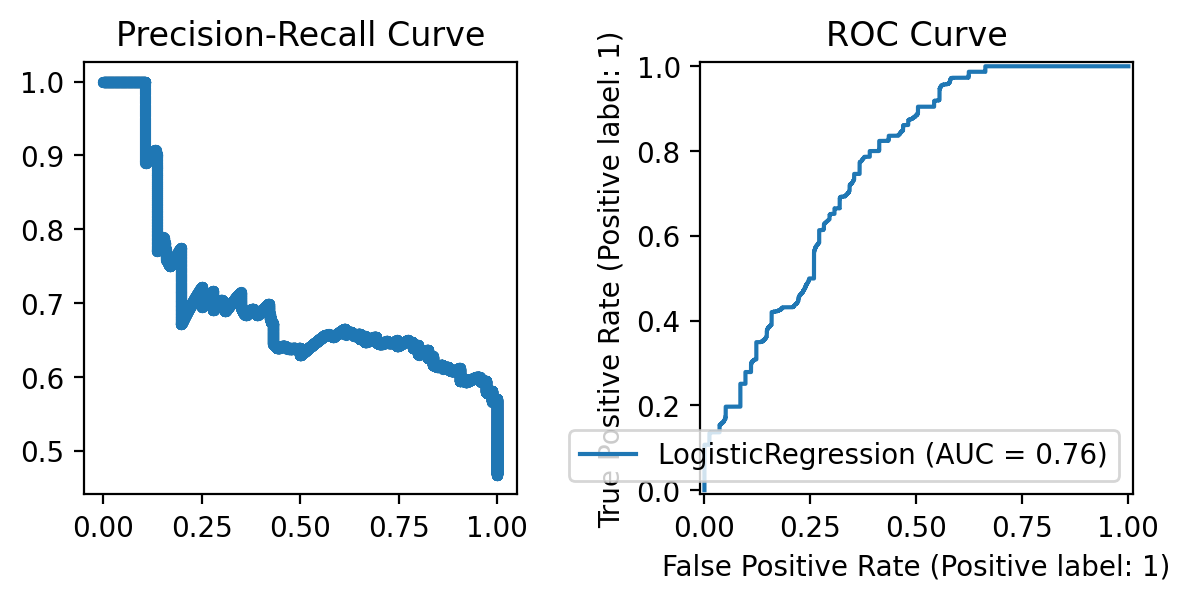

In [ ]:
# Train model then report performance
#

# Train model
_ = train_report_scores(df, 'treatment', LogisticRegression(max_iter=1000, random_state=234), plot=True)


- Accuracy is at **0.69** without pre-processing.
- The AUC is **0.75**, which is decent but has the potential for improvement.
- Precision and f1 for Class 0 is barely good at 71 and 70. While Recall is low.

We will explore other means of improving this performance.


### 6.2 Train Country Models

In [ ]:
# Train model then report performance or errors
#

def get_LR_model():
    return LogisticRegression(max_iter=1000, random_state=234)

# Train model
evaluate_by_feature_country(df, get_LR_model)


**Country Accuracy, Performance:**
- **Brazil**: 0.7842, 0.9052
- **Canada**: 0.6686, 0.7781
- **Ireland**: 0.8541, 1.0000
- **Netherlands**: 0.6968, 0.8211 
- **Sweden**: 0.7438, 0.8894
- **Switzerland**: 0.7019, 0.8517
- **UK**: 0.566, 0.4988
- **US**: 0.4943, 0.4764

**Countries with 100% Accuracy:**
- Germany
- India
- New Zealand

**Others:**
- Only one category found, either having 'Yes' or 'No', but not both.
  
**Error:**
- South Africa - Test failed! The test variable only has one category (Yes).


### 6.3 Cross-Validation Score by Country

- Explore high performing countries and see if we can improve prediction by segmenting this group.
- Segment the countries into two groups: high-performing and low-performing. Each segment will be trained as a separate model and see if we can optimize for performance and accuracy.
- Ignore other countries that are higly imbalanced (has either Class0 or Class1 but not both), and countries with perfect scores (Overfitting).

In [ ]:
target = 'treatment'
hperf_ctry = np.empty((0, 2), dtype=object)
lperf_ctry = np.empty((0, 2), dtype=object)

col_countries = [col for col in df.columns if col.startswith('Country_')]

# Iterate over each country and run cross-validation
for country_col in col_countries:
    country_df = df[df[country_col] == 1]
    # Do not include countries for single category targets (perfectly imbalanced)
    vc = country_df.treatment.value_counts()
    if vc.count() > 1:
        X = country_df.drop(columns=[target])
        y = country_df[target]
        
        # Perform cross-validation
        scores = cross_val_score(LogisticRegression(max_iter=1000, random_state=234), X, y, cv=5)
        mean_score = scores.mean()
        if mean_score != 1: # Exclude countries with perfect accuracy.
            arr = np.array([[country_col, f'{country_col}: {mean_score:.4f}']])
            if mean_score > 0.7: 
                hperf_ctry = np.append(hperf_ctry, arr, axis=0)
            else:
                lperf_ctry = np.append(lperf_ctry, arr, axis=0)
            
print(f'High Peforming Countries:\n\n{"\n".join(hperf_ctry[:,1])}')
print(f'\nLow Peforming Countries:\n\n{"\n".join(lperf_ctry[:,1])}\n')


### 6.4 Train High-impact and Low-impact Segments separately

In [ ]:
# Combine data for all high-impact countries
hperf_df = pd.DataFrame()
for country_col in hperf_ctry[:,0]:
    country_df = df[df[country_col] == 1]
    hperf_df = pd.concat([hperf_df, country_df], axis=0)

# Combine data for all high-impact countries
lperf_df = pd.DataFrame()
for country_col in lperf_ctry[:,0]:
    country_df = df[df[country_col] == 1]
    lperf_df = pd.concat([lperf_df, country_df], axis=0)



In [ ]:
print(f'High Impact Countries shape: {hperf_df.shape}')
print(f'Low Impact Countries shape: {lperf_df.shape}')

#### 6.4.1 Train High-impact model

In [ ]:
# Train model for high-impact countries
model = LogisticRegression(max_iter=1000, random_state=234)
_ = train_report_scores(hperf_df, 'treatment', model, plot=True)


#### 6.4.2 Train Low-Impact model

In [ ]:
# Train model for high-impact countries
model = LogisticRegression(max_iter=1000, random_state=234)
_ = train_report_scores(lperf_df, 'treatment', model, plot=True)


## 7. Summary

#### Objective: 
- This analysis investigated the predictive performance of the mental health model and evaluated its effectiveness as a global predictor, as well as across different countries.
- The classifier used for this analysis is LogisticRegression.

#### Initial Global Model Development:

- Developed an initial global model using the mental health dataset.
- The evaluation showed that the model scores are fair, they are not satisfactory for effective predictions. It requires more improvement.

#### Cross-Validation (CV) Scores Capture:

- Captured cross-validation scores for each country in the dataset.
- Identified several countries that could not be effectively modeled due to data quality or availability issues.

#### Segmentation Analysis:

- Conducted a segmentation analysis to categorize countries into high and low impact based on their mental health indicators.
- Results showed minimal performance improvements, with both high and low impact countries exhibiting lower accuracy and performance levels.

#### Findings:
- The global model performance shows the need to further refine feature selection gain improved predictive accuracy.
- Some countries can not be modeled due to gaps in the data that prevented further analysis.
- The analysis results of the segmented countries suggests that external factors may be influencing model performance, it needs further investigation of country-specific characteristics and data quality.

#### Next Steps:
- Data Quality Improvement: Focus on improving data quality, especially for countries that currently lack enough data for modeling.
- Feature Refinement: Explore additional feature engineering techniques to improve the model's ability to capture relevant patterns in segmented analyses.
- Model Exploration: Explore other modeling techniques in to assess their effectiveness to enhance prediction.
- Country-Specific Models: Developing a separate model for countries with significantly different characteristics to improve overall accuracy and performance.
 